# Natural Languange Processing (NLP)- Advanced Topics in DL

Group Z:</br>
    - Iliya Morgunov - 206361412</br>
    - Eadan Schechter - 209793553

# Imports

In [5]:
#pip install wordcloud

In [6]:
#pip install plotly

In [7]:
#pip install matplotlib-venn

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import plotly.express as px

import re
import string
from collections import Counter, defaultdict
from datetime import datetime
from tqdm import tqdm


# Part 1

## Data Overview

In this section, we load the datasets and explore their basic properties. We display the shape of the data, examine the columns, and review a few rows to get an initial sense of the content. This helps us understand the structure, spot potential issues, and plan subsequent analysis steps.

In [9]:
# Load datasets
df_train = pd.read_csv("Corona_NLP_train.csv", encoding="latin1")
df_test = pd.read_csv("Corona_NLP_test.csv", encoding="latin1")

In [10]:
# Basic info
print("Train Data Shape:", df_train.shape)
print("Data Columns:", df_train.columns)
display(df_train.head())

Train Data Shape: (41157, 6)
Data Columns: Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [11]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None


In [12]:
print(df_train.describe())

           UserName    ScreenName
count  41157.000000  41157.000000
mean   24377.000000  69329.000000
std    11881.146851  11881.146851
min     3799.000000  48751.000000
25%    14088.000000  59040.000000
50%    24377.000000  69329.000000
75%    34666.000000  79618.000000
max    44955.000000  89907.000000


In this initial overview, we loaded the tweet sentiment dataset and examined its structure and key features. The dataset includes six columns, of which 'OriginalTweet' (tweet text) and 'Sentiment' (target label) are central to our modeling pipeline.

We observed a large number of missing values in the 'Location' column, while the rest of the columns are largely complete. Some columns like 'TweetAt' and user identifiers are present but not directly useful in raw form for NLP tasks. This inspection guides our next steps - focusing on deeper exploratory analysis, targeted text cleaning, and thoughtful encoding of variables relevant to our classification goal.


## Missing Values and Duplicates

Here, we investigate missing values and duplicated entries in both the training and test sets. Identifying missing or repeated data is crucial for both data cleaning and ensuring that our analysis and modeling are not biased or affected by data quality issues.

In [13]:
# Check for missing values in train set
print(df_train.isna().sum())

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [14]:
# Check for missing values in test set
print(df_test.isna().sum())

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


In [15]:
# Check for duplicates in train set
duplicates = df_train.duplicated(subset=['OriginalTweet']).sum()
print(f"Number of duplicate tweets texts in train: {duplicates}")

Number of duplicate tweets texts in train: 0


In [16]:
# Check for duplicates in test set
duplicates = df_test.duplicated(subset=['OriginalTweet']).sum()
print(f"Number of duplicate tweets texts in test: {duplicates}")

Number of duplicate tweets texts in test: 0


In this section, we checked for missing values and duplicate entries in both the training and test datasets. We found that only the ‘Location’ column contains missing data; all other columns are complete.

No duplicate tweets (based on their textual content) exist in either the training or test set, indicating that the data is free of repeated content that could bias our analysis or artificially inflate model performance.

Our next step will involve imputing missing values in the 'Location' column for descriptive purposes, while modeling based on text can proceed without concern.

## Label (Target) Distribution

We examine the distribution of the target variable ('Sentiment') to assess class balance. Visualizing sentiment counts and proportions helps us identify any imbalance, which may influence modeling choices  and evaluation metrics

In [17]:
print("Sentiment label counts:\n", df_train["Sentiment"].value_counts())

Sentiment label counts:
 Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


In [18]:
print("\nSentiment label proportions:\n", df_train["Sentiment"].value_counts(normalize=True).round(3))


Sentiment label proportions:
 Sentiment
Positive              0.278
Negative              0.241
Neutral               0.187
Extremely Positive    0.161
Extremely Negative    0.133
Name: proportion, dtype: float64


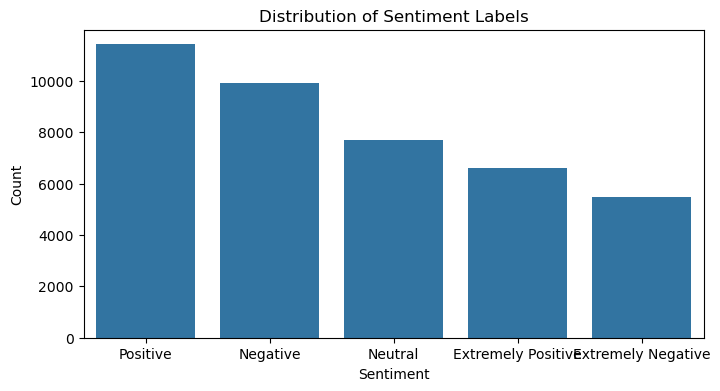

In [19]:
# Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='Sentiment', data=df_train, order=df_train['Sentiment'].value_counts().index)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

We visualized and quantified the class distribution of sentiment labels in the dataset. The most common class is ‘Positive’ (28%), followed by ‘Negative’ (24%), with ‘Neutral’ and the extreme sentiments (‘Extremely Positive’ and ‘Extremely Negative’) being less frequent.

While the distribution is not severely imbalanced, the relative scarcity of extreme sentiment classes may hinder the model’s ability to learn them effectively. To address this, we plan to use stratified sampling and macro-averaged evaluation metrics in our modeling, ensuring balanced performance across all sentiment categories.

### Text Length Analysis

We analyze the length of tweets in terms of both character and word counts, overall and by sentiment. This informs us about the typical size of the text samples and reveals whether certain sentiments are associated with longer or shorter tweets. These statistics also guide our choices for preprocessing, such as padding and max length.

In [20]:
# Add columns for tweet length in characters and words
df_train['text_length_chars'] = df_train['OriginalTweet'].astype(str).apply(len)
df_train['text_length_words'] = df_train['OriginalTweet'].astype(str).apply(lambda x: len(x.split()))

#### Characters

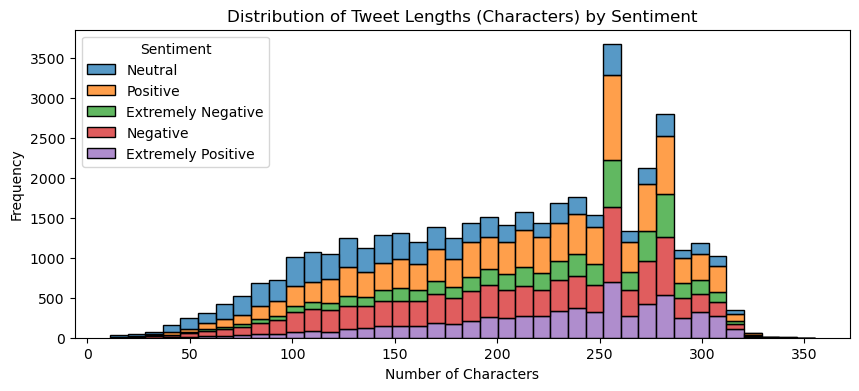

In [21]:
# Plot distributions of tweet lengths (characters), stacked by sentiment
plt.figure(figsize=(10,4))
sns.histplot(data=df_train, x='text_length_chars', hue='Sentiment', multiple='stack', bins=40)
plt.title("Distribution of Tweet Lengths (Characters) by Sentiment")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

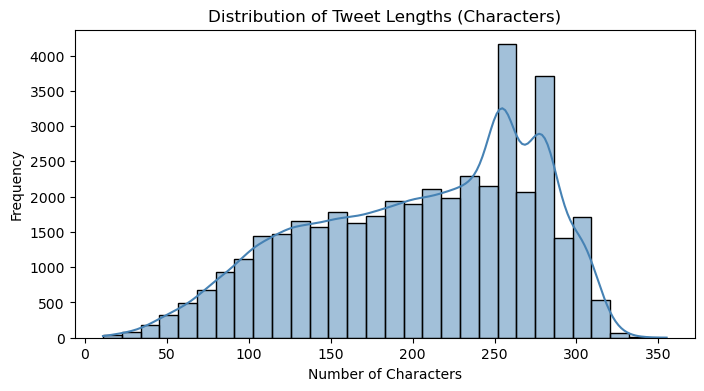

In [22]:
# Plot overall distribution of tweet lengths (characters)
plt.figure(figsize=(8, 4))
sns.histplot(df_train['text_length_chars'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Tweet Lengths (Characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

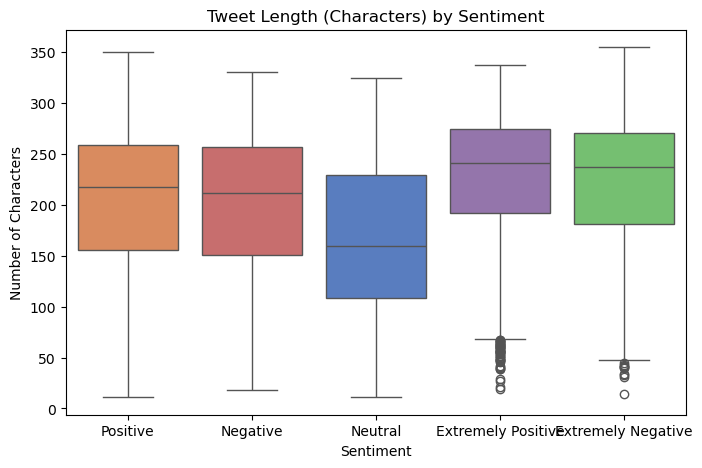

In [23]:
# Boxplot of tweet lengths (characters) by sentiment
plt.figure(figsize=(8,5))
sns.boxplot(x='Sentiment', y='text_length_chars', hue='Sentiment',
            data=df_train, order=df_train['Sentiment'].value_counts().index,
            palette='muted', legend=False)
plt.title("Tweet Length (Characters) by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Characters")
plt.show()

#### Words

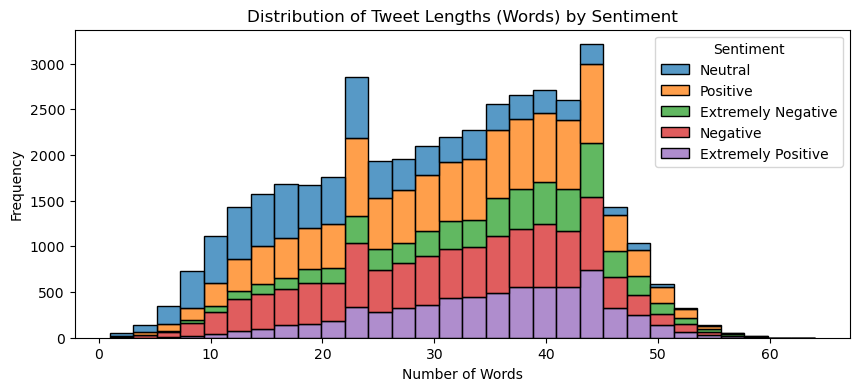

In [24]:
# Distribution of tweet lengths (words), stacked by sentiment
plt.figure(figsize=(10,4))
sns.histplot(data=df_train, x='text_length_words', hue='Sentiment', multiple='stack', bins=30)
plt.title("Distribution of Tweet Lengths (Words) by Sentiment")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

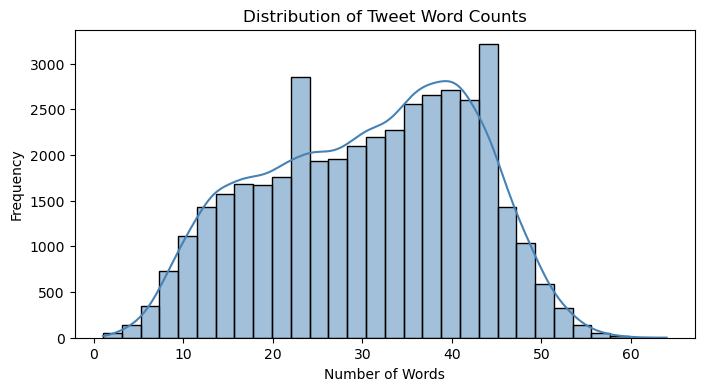

In [25]:
# Overall distribution of tweet word counts
plt.figure(figsize=(8, 4))
sns.histplot(df_train['text_length_words'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Tweet Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

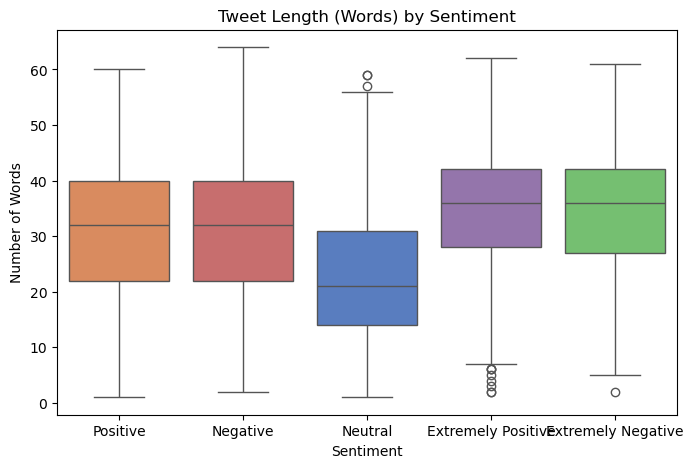

In [26]:
# Boxplot of tweet lengths (words) by sentiment
plt.figure(figsize=(8,5))
sns.boxplot(
    x='Sentiment',
    y='text_length_words',
    hue='Sentiment',
    data=df_train,
    order=df_train['Sentiment'].value_counts().index,
    palette='muted',
    legend=False
)
plt.title("Tweet Length (Words) by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()

#### Summary Statistics

In [27]:
# Average word count by class
print("Average word count by sentiment:\n", df_train.groupby('Sentiment')['text_length_words'].mean().round(2))

Average word count by sentiment:
 Sentiment
Extremely Negative    34.46
Extremely Positive    34.85
Negative              30.65
Neutral               23.14
Positive              30.92
Name: text_length_words, dtype: float64


In [28]:
# Summary statistics table
summary_stats = df_train.groupby('Sentiment')[['text_length_chars', 'text_length_words']].describe().round(2)
display(summary_stats)

text_length_chars                                     \
                               count    mean    std   min    25%    50%   
Sentiment                                                                 
Extremely Negative            5481.0  221.48  59.99  14.0  181.0  237.0   
Extremely Positive            6624.0  228.24  58.39  19.0  192.0  241.0   
Negative                      9917.0  203.33  67.12  18.0  151.0  212.0   
Neutral                       7713.0  168.16  72.65  11.0  109.0  160.0   
Positive                     11422.0  207.06  66.65  11.0  156.0  218.0   

                                 text_length_words                           \
                      75%    max             count   mean    std  min   25%   
Sentiment                                                                     
Extremely Negative  271.0  355.0            5481.0  34.46  10.47  2.0  27.0   
Extremely Positive  275.0  338.0            6624.0  34.85   9.73  2.0  28.0   
Negative            257.0  331.0            9917.0  30.65  11.34  2.0  22.0   
Neutral             229.0  325.0            7713.0  23.14  11.21  1.0  14.0   
Positive            259.0  350.0           11422.0  30.92  11.17  1.0  22.0   

                                      
                     50%   75%   max  
Sentiment                             
Extremely Negative  36.0  42.0  61.0  
Extremely Positive  36.0  42.0  62.0  
Negative            32.0  40.0  64.0  
Neutral             21.0  31.0  59.0  
Positive            32.0  40.0  60.0

In [29]:
# Quantiles of length
print("Word count quantiles (for max_len selection):\n", df_train['text_length_words'].quantile([0.95, 0.99, 1.0]))

Word count quantiles (for max_len selection):
 0.95    48.0
0.99    52.0
1.00    64.0
Name: text_length_words, dtype: float64


In this section, we performed a comprehensive analysis of tweet lengths across sentiments, measuring both character and word counts. We observed that nearly all tweets fall below 350 characters and 64 words, with only a small proportion of longer outliers. Neutral tweets tend to be shorter, while extremely positive and negative sentiments are often expressed in longer tweets.

These insights initially guided our preprocessing pipeline: we chose a sequence length (`max_len`) of 64 for tokenization to avoid truncating most tweets while minimizing excessive padding. This ensured efficiency without sacrificing content coverage.

At this stage, our goal was to optimize input length for standard token-level modeling. However, as we progressed, we adopted a different strategy - enriching tweets with contextual metadata (such as date, location, and resolved URLs). This change led us to move beyond raw length-based optimization and instead focus on how to structure richer inputs for a language model.

Nonetheless, this length analysis remains an important step in understanding the natural boundaries of the raw tweet data and helped inform several early modeling considerations.

### N-gram Analysis

In this section, we extract and visualize the most common bigrams (two-word sequences) and trigrams for each sentiment category in the training set. By analyzing these N-grams, we uncover frequent phrase patterns, topic-specific terms, and distinctive expressions that characterize each sentiment. For example, positive tweets often feature encouraging or supportive language, while negative sentiments may cluster around complaints or frustrations.

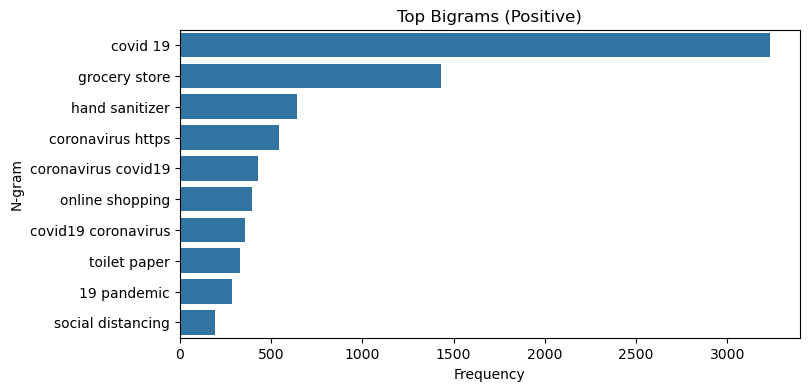

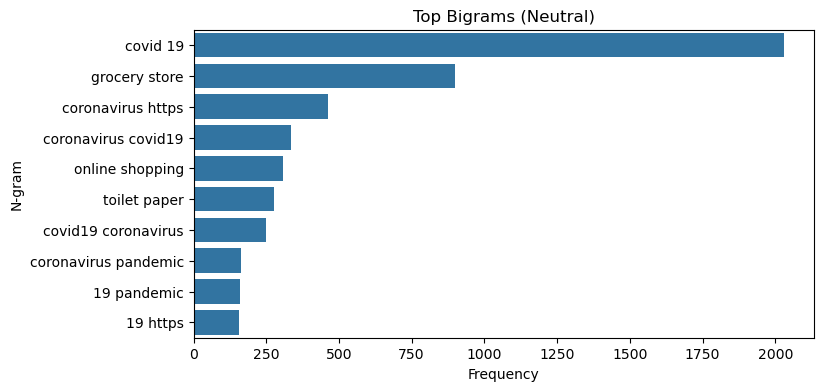

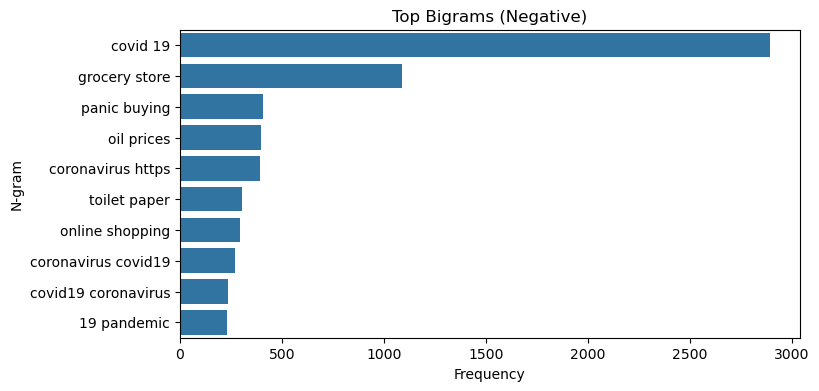

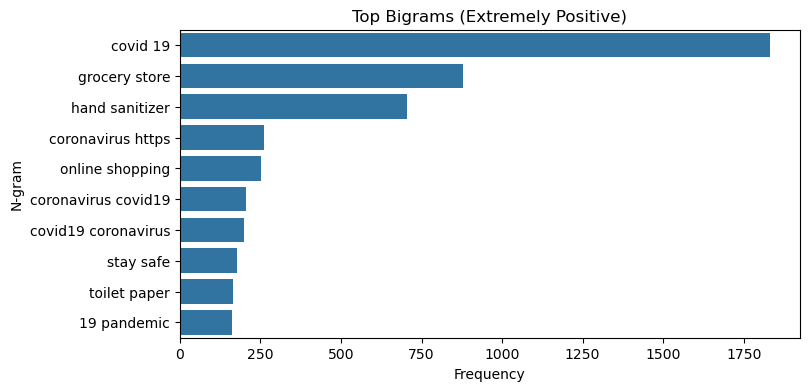

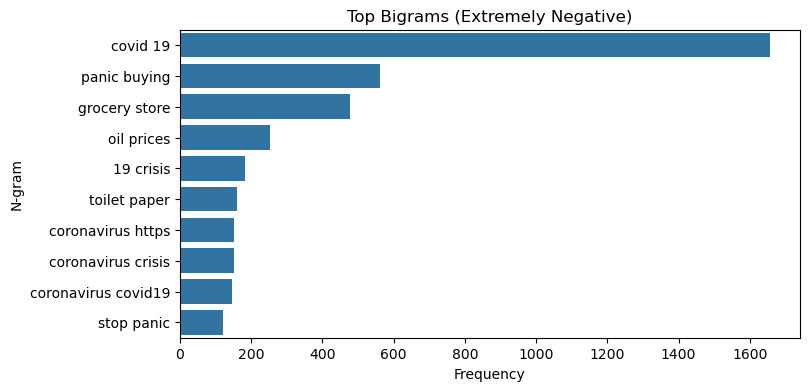

In [30]:
def plot_top_ngrams(corpus, ngram_range=(2,2), n=10, title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    if words_freq:  # Avoid errors if there are no ngrams
        x, y = zip(*words_freq)
        plt.figure(figsize=(8, 4))
        sns.barplot(x=list(y), y=list(x))
        plt.title(title)
        plt.xlabel('Frequency')
        plt.ylabel('N-gram')
        plt.show()
    else:
        print(f"No {title} found.")

# Sentiment list
sentiment_name_lst = ["Positive", "Neutral", "Negative", "Extremely Positive", "Extremely Negative"]

# Loop for Bigrams
for sentiment in sentiment_name_lst:
    plot_top_ngrams(
        df_train[df_train['Sentiment'] == sentiment]['OriginalTweet'],
        ngram_range=(2,2),
        title=f"Top Bigrams ({sentiment})"
    )

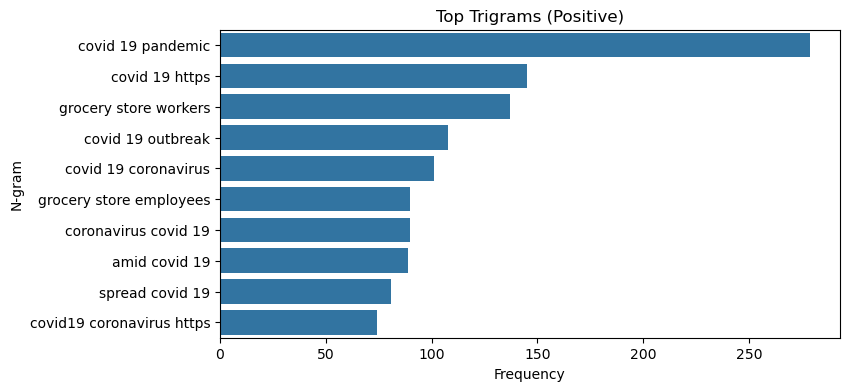

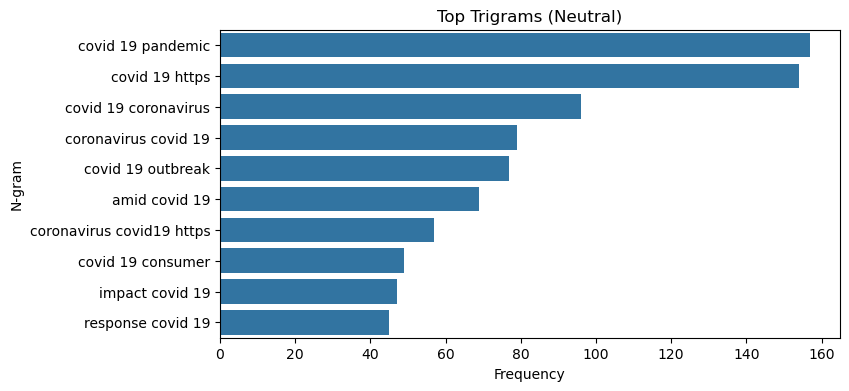

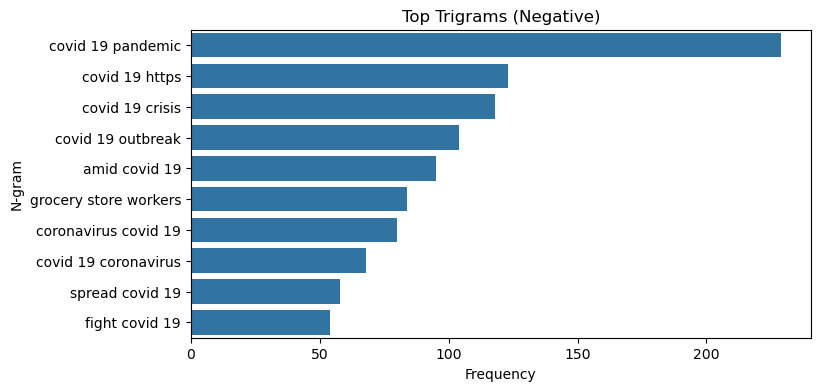

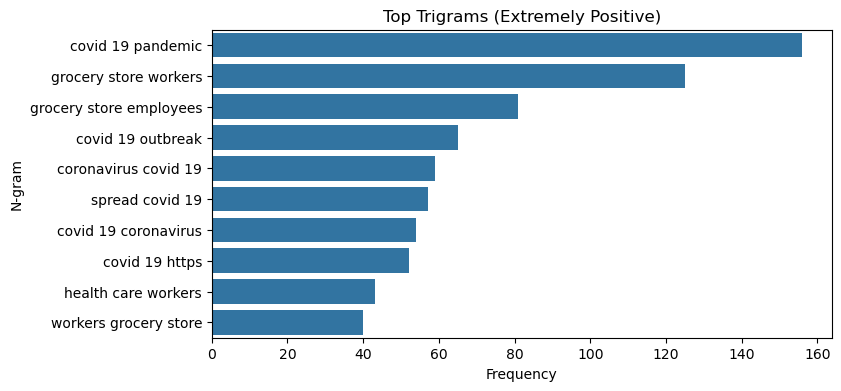

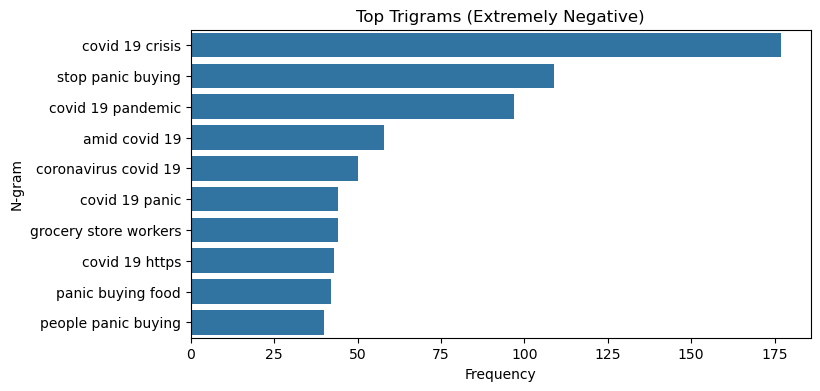

In [31]:
# Loop for trigrams
for sentiment in sentiment_name_lst:
    plot_top_ngrams(
        df_train[df_train['Sentiment'] == sentiment]['OriginalTweet'],
        ngram_range=(3,3),
        title=f"Top Trigrams ({sentiment})"
    )

Through systematic N-gram analysis, we identified recurring bigrams and trigrams unique to each sentiment category. Unsurprisingly, the phrase “covid 19” dominates across all classes, reflecting the dataset’s pandemic context. However, examining the second-tier n-grams reveals more sentiment-specific language: for example, positive and extremely positive tweets emphasize safety (“hand sanitizer”, “stay safe”, “grocery store workers”), while negative and extremely negative tweets are rich in terms related to crisis and fear (“panic buying”, “oil prices”, “stop panic buying”, “covid 19 crisis”). Neutral tweets more often focus on events (“coronavirus pandemic”, “online shopping”) with less emotionally charged vocabulary. This analysis not only confirms the domain relevance of the dataset but also suggests that sentiment signals are frequently expressed through concise, multi-word phrases rather than isolated words. Such insights support the use of transformer-based models capable of capturing contextual and phrasal meaning, and justify future experiments with N-gram-based features or embeddings. Overall, n-gram exploration reveals both common public concerns and subtle differences in how users express sentiment during the pandemic, deepening our understanding of the linguistic landscape our models must interpret.

## Word Clouds & Most Common Terms (Words)

To further explore the language used in the dataset, we generate word clouds showing the most frequent words overall and by sentiment class. This provides an intuitive, visual summary of the most prominent topics and terms in the dataset, highlighting key differences between sentiment categories.

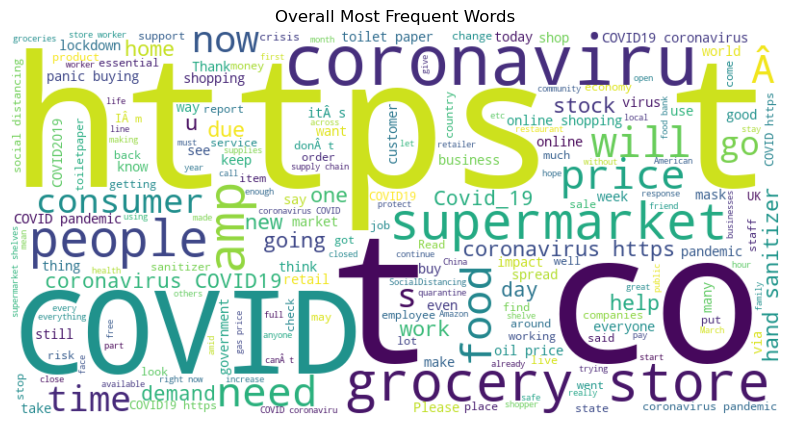

In [32]:
# Overall word cloud
text = " ".join(df_train['OriginalTweet'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Overall Most Frequent Words")
plt.show()

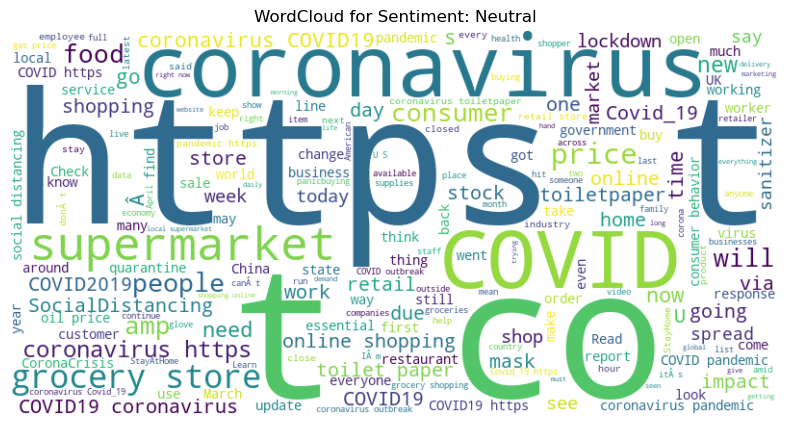

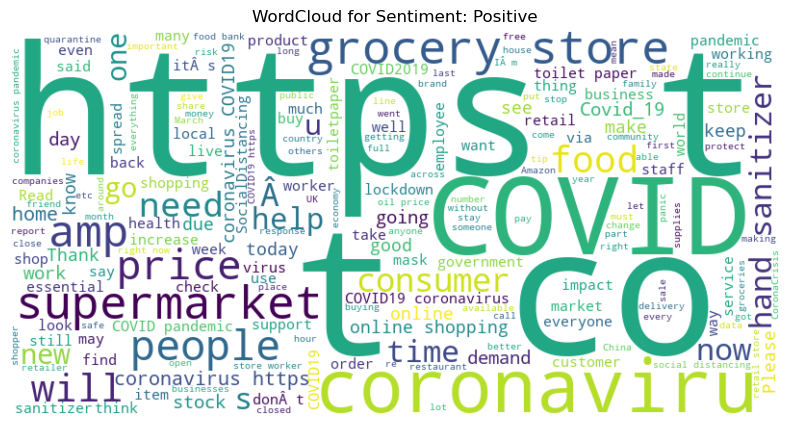

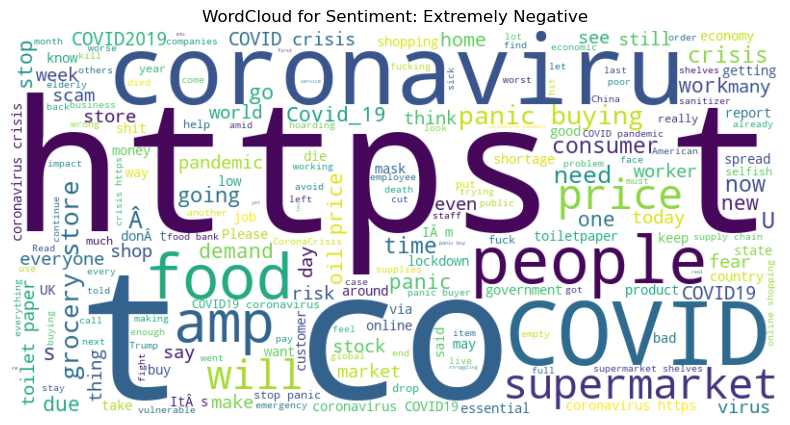

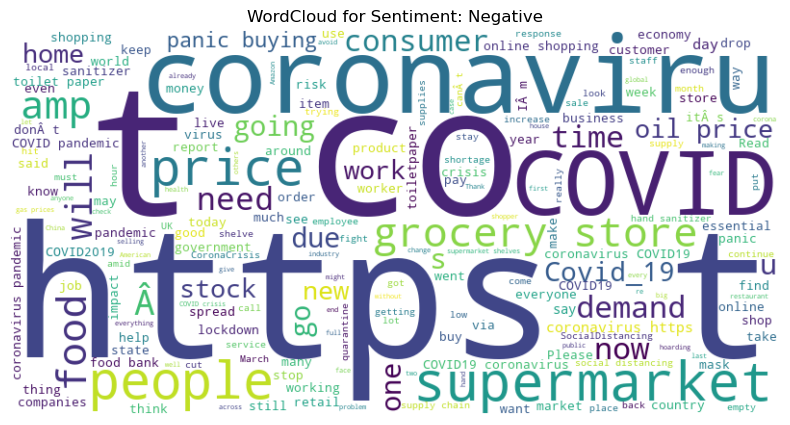

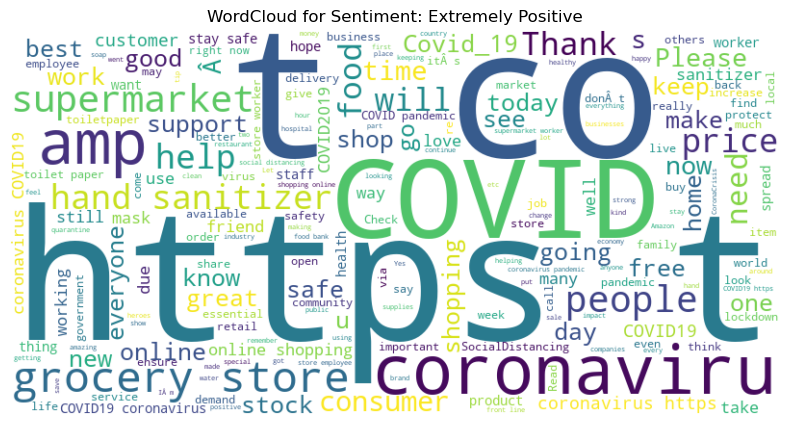

In [33]:
# Wordcloud per class
for sentiment in df_train['Sentiment'].unique():
    text = " ".join(df_train[df_train['Sentiment'] == sentiment]['OriginalTweet'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Sentiment: {sentiment}")
    plt.show()

In this section, we leveraged word clouds to visually summarize the most frequent words in the dataset, both overall and within each sentiment category. This approach provides an immediate sense of the dominant vocabulary, topical focus, and characteristic language patterns associated with different sentiments. As expected, pandemic-related terms such as "covid," "coronavirus," "grocery store," "toilet paper," and "hand sanitizer" appear prominently across all classes, reflecting the shared global context.

However, one particularly striking finding is the overwhelming presence of the token "https" - far more dominant than even "coronavirus" in some visualizations. This indicates that URLs are not just frequent, but central to how users communicated during the early COVID-19 period. The presence of shortened or embedded links is consistent across sentiments, reinforcing the role of link-sharing on Twitter during the pandemic.

Traditionally, in standard preprocessing pipelines, URLs are removed as they are considered uninformative - typically just random strings or redirect domains that add noise. But this dataset challenged that assumption. Given their overwhelming prevalence and visual prominence, we hypothesized that these URLs might still carry indirect signal - for example, pointing to emotionally charged news, opinion articles, or official guidelines.

Instead of removing them outright, we designed a strategy to resolve these URLs and extract their descriptions or titles, incorporating this as structured input. This allowed us to preserve potentially valuable context while avoiding noise from raw link tokens. We show this enrichment step in detail later in the preprocessing pipeline.

In conclusion, the word cloud analysis not only reveals the topical content of the tweets but also helps us detect overlooked patterns like the dominance of URLs - a factor that significantly influenced our design choices for data representation and model input.

## Temporal Patterns

We analyze the time-related aspects of the data, including the distribution of tweets over days, months, and weekdays. By visualizing sentiment trends over time, we can identify temporal patterns, such as shifts in public mood, responses to events, or weekly cycles in activity.

In [34]:
# Check how many unique dates the data holds
train_unique = df_train["TweetAt"].nunique()
test_unique = df_test["TweetAt"].nunique()

print(f"The training data has {train_unique} unique dates")
print(f"The test data has {test_unique} unique dates")

The training data has 30 unique dates
The test data has 15 unique dates


In [35]:
# Check if train and test have the same unique dates - Compare the unique sets of dates in both datasets

# Parse dates
df_train['TweetAt'] = pd.to_datetime(df_train['TweetAt'], format='%d-%m-%Y', errors='coerce')
df_test['TweetAt'] = pd.to_datetime(df_test['TweetAt'], format='%d-%m-%Y', errors='coerce')

train_dates = set(df_train['TweetAt'].unique())
test_dates = set(df_test['TweetAt'].unique())

# Dates in both
common_dates = train_dates & test_dates
only_train = train_dates - test_dates
only_test = test_dates - train_dates

print(f"Dates in both train and test: {sorted(list(common_dates))}")
print(f"Dates only in train: {sorted(list(only_train))}")
print(f"Dates only in test: {sorted(list(only_test))}")

print(f"\nTrain dates count: {len(train_dates)}, Test dates count: {len(test_dates)}, Shared: {len(common_dates)}")

Dates in both train and test: [Timestamp('2020-03-16 00:00:00')]
Dates only in train: [Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-21 00:00:00'), Timestamp('2020-03-22 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'), Timestamp('2020-03-28 00:00:00'), Timestamp('2020-03-29 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-04-02 00:00:00'), Timestamp('2020-04-03 00:00:00'), Timestamp('2020-04-04 00:00:00'), Timestamp('2020-04-05 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-07 00:00:00'), Timestamp('2020-04-08 00:00:00'), Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-10 00:00:00'), Timestamp('2020-04-11 00:00:00'), Timestamp('2020-04-12 00:00:0

In [36]:
# First, convert the "TweetAt" column (which is "DD-MM-YYYY") into a pandas datetime type, and extract day, month, year, and weekday.

# Parse the date
df_train['TweetAt'] = pd.to_datetime(df_train['TweetAt'], format='%d-%m-%Y', errors='coerce')

# Extract day, month, weekday
df_train['day'] = df_train['TweetAt'].dt.day
df_train['month'] = df_train['TweetAt'].dt.month
df_train['weekday'] = df_train['TweetAt'].dt.day_name()

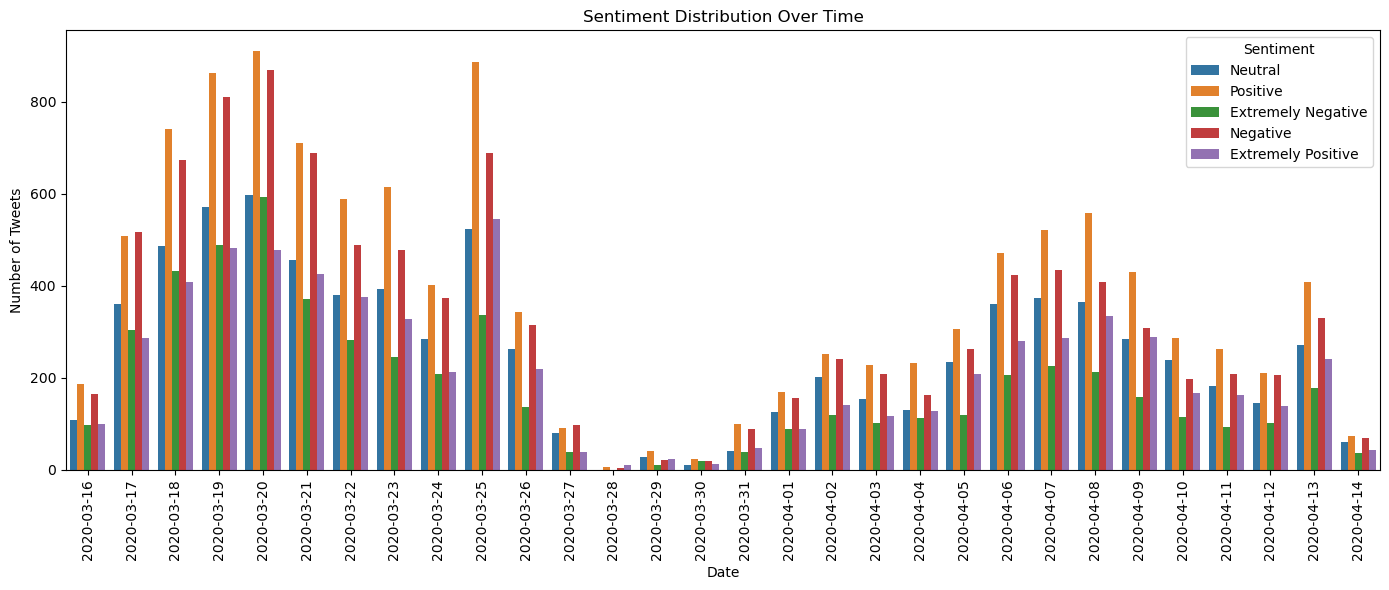

In [37]:
# Plot sentiment counts over time by date

plt.figure(figsize=(14,6))
sns.countplot(data=df_train, x='TweetAt', hue='Sentiment', order=sorted(df_train['TweetAt'].dropna().unique()))
plt.xticks(rotation=90)
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

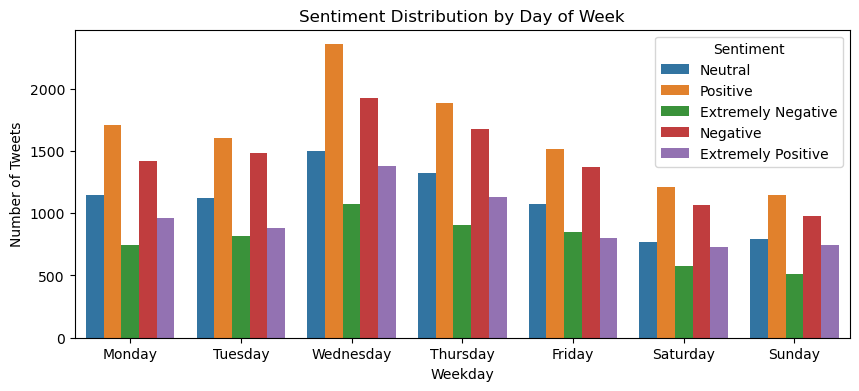

In [38]:
# Sentiment by Weekday - Which days of the week are more positive/negative?

plt.figure(figsize=(10,4))
sns.countplot(data=df_train, x='weekday', hue='Sentiment', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Sentiment Distribution by Day of Week')
plt.xlabel('Weekday')
plt.ylabel('Number of Tweets')
plt.show()

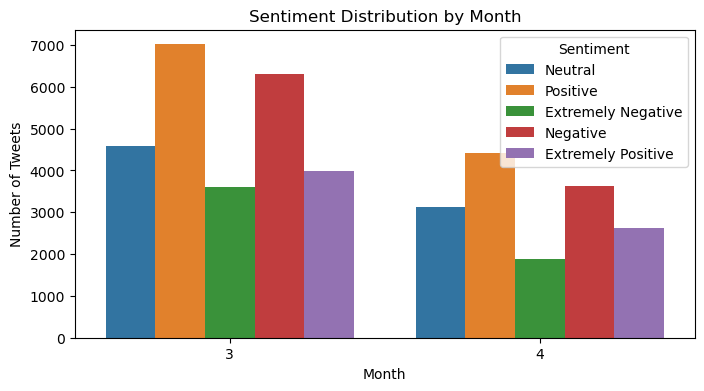

In [39]:
# Sentiment by Month
plt.figure(figsize=(8,4))
sns.countplot(data=df_train, x='month', hue='Sentiment')
plt.title('Sentiment Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

In this part of our analysis, we explored the temporal dimension of the dataset by visualizing tweet volumes and sentiment distributions across dates, weekdays, and months. As expected, we observed pronounced spikes in activity during mid-March 2020, likely reflecting public reaction to early COVID-19 developments, with positive and negative tweets being the most dominant sentiments.

However, while overall volume clearly varied by date, we did **not observe any consistent or meaningful sentiment patterns across weekdays or months**. Weekday distributions showed expected behavioral shifts (e.g., fewer tweets on weekends), but sentiment proportions remained relatively stable. Similarly, while March had higher tweet volumes than April, sentiment trends by month were not strongly differentiated.

Given this, we chose to focus on more **granular and semantically meaningful time features**: the **day of the month (numeric)** and the **month index**. These variables retain finer temporal resolution and may better capture specific events or policy changes that influenced public sentiment - unlike weekday names or high-level monthly aggregates, which are less likely to carry sentiment-relevant signal.

Importantly, we also found that only one date - March 16, 2020 - is shared between the train and test sets. This suggests a temporal shift in test data, which may introduce generalization challenges. These insights emphasize the importance of treating time-related variables carefully, both as potential features and in designing validation strategies.

## Location-Based Sentiment Analysis

We examine the 'Location' field to study the geographic distribution of tweets and how sentiment varies across different places. We impute missing values, explore the most common locations, and map cities to countries. This allows us to visualize the spatial spread of the dataset and assess potential regional differences in sentiment.

In [40]:
# Check for missing values in train set
print(df_train.isna().sum())

UserName                0
ScreenName              0
Location             8590
TweetAt                 0
OriginalTweet           0
Sentiment               0
text_length_chars       0
text_length_words       0
day                     0
month                   0
weekday                 0
dtype: int64


In [41]:
# Show all unique locations (as a list)
unique_locations = df_train['Location'].unique()
print(unique_locations)
print(f"\nNumber of unique locations: {len(unique_locations)}")

print(df_train['Location'].value_counts().head(30))

['London' 'UK' 'Vagabonds' ... 'Juba south sudan' 'OHIO'
 'i love you so much || he/him']

Number of unique locations: 12221
Location
London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
New Delhi, India           138
Atlanta, GA                126
New York                   126
Mumbai, India              109
Worldwide                  101
Lagos, Nigeria              99
Houston, TX                 98
Austin, TX                  9

In [42]:
# Before imputation, check how many rows are already labeled 'Unknown' (as a value, not missing)
print("Rows with literal 'Unknown' before imputation:", (df_train['Location'] == 'Unknown').sum())
print("Rows with missing (NaN) before imputation:", df_train['Location'].isna().sum())

Rows with literal 'Unknown' before imputation: 3
Rows with missing (NaN) before imputation: 8590


In [43]:
# Impute Missing Locations with a placeholder (e.g., “Unknown”)
df_train['Location'] = df_train['Location'].fillna('Unknown')
print("Rows with 'Unknown' after imputation:", (df_train['Location'] == 'Unknown').sum())

Rows with 'Unknown' after imputation: 8593


After imputing missing values in the 'Location' column with the placeholder `'Unknown'`, a significant portion of tweets - approximately 17% - are now labeled as having unknown locations. This includes both originally missing entries and a small number of tweets that already had `'Unknown'` as their reported location.

This step ensures that all records contain a valid string value for the `Location` field, which simplifies downstream analysis and grouping operations. However, the high proportion of unknowns highlights the noisy and incomplete nature of self-reported location data on social media platforms.

In [44]:
# Explore Most Frequent Locations - top 10 locations by tweet count
top_locations = df_train['Location'].value_counts().head(10)
display(top_locations)

Location
Unknown            8593
London              540
United States       528
London, England     520
New York, NY        395
Washington, DC      373
United Kingdom      337
Los Angeles, CA     281
India               268
UK                  232
Name: count, dtype: int64

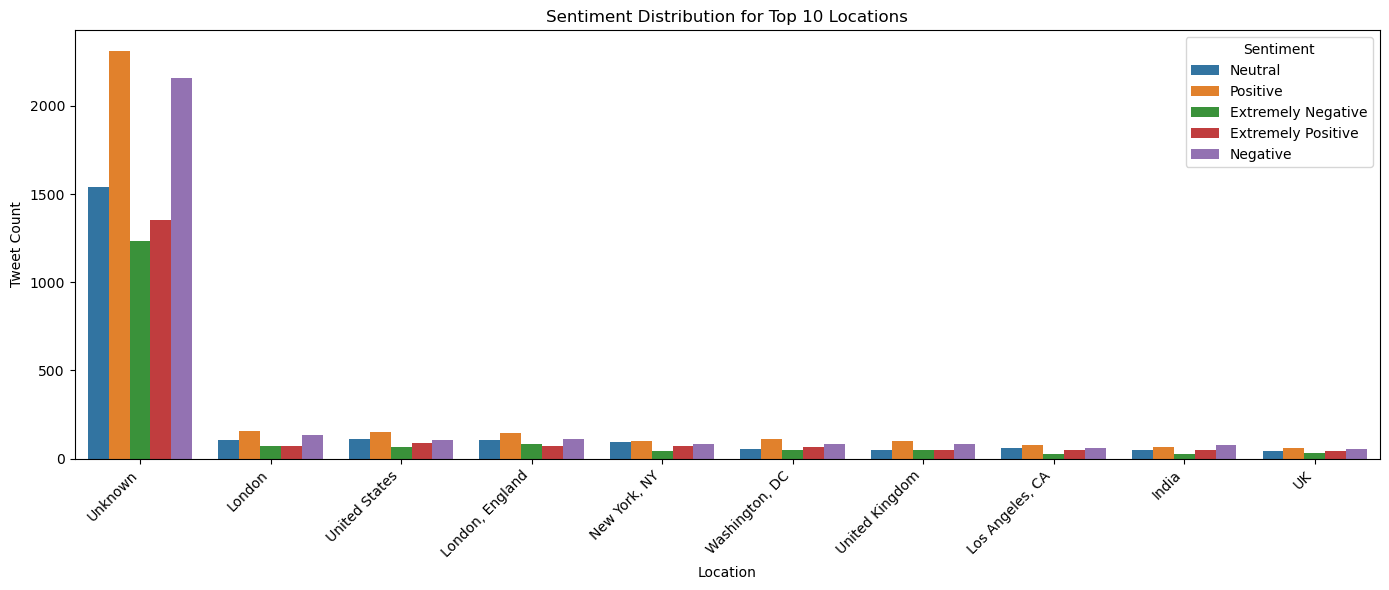

In [45]:
# Sentiment Distribution by Location - plot the distribution of sentiments for the most common location - Are some locations more positive/negative?

# Barplot for top N locations:
N = 10
top_N_locations = df_train['Location'].value_counts().head(N).index
df_top_locations = df_train[df_train['Location'].isin(top_N_locations)]

plt.figure(figsize=(14, 6))
sns.countplot(data=df_top_locations, x='Location', hue='Sentiment', order=top_N_locations)
plt.title(f'Sentiment Distribution for Top {N} Locations')
plt.xlabel('Location')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

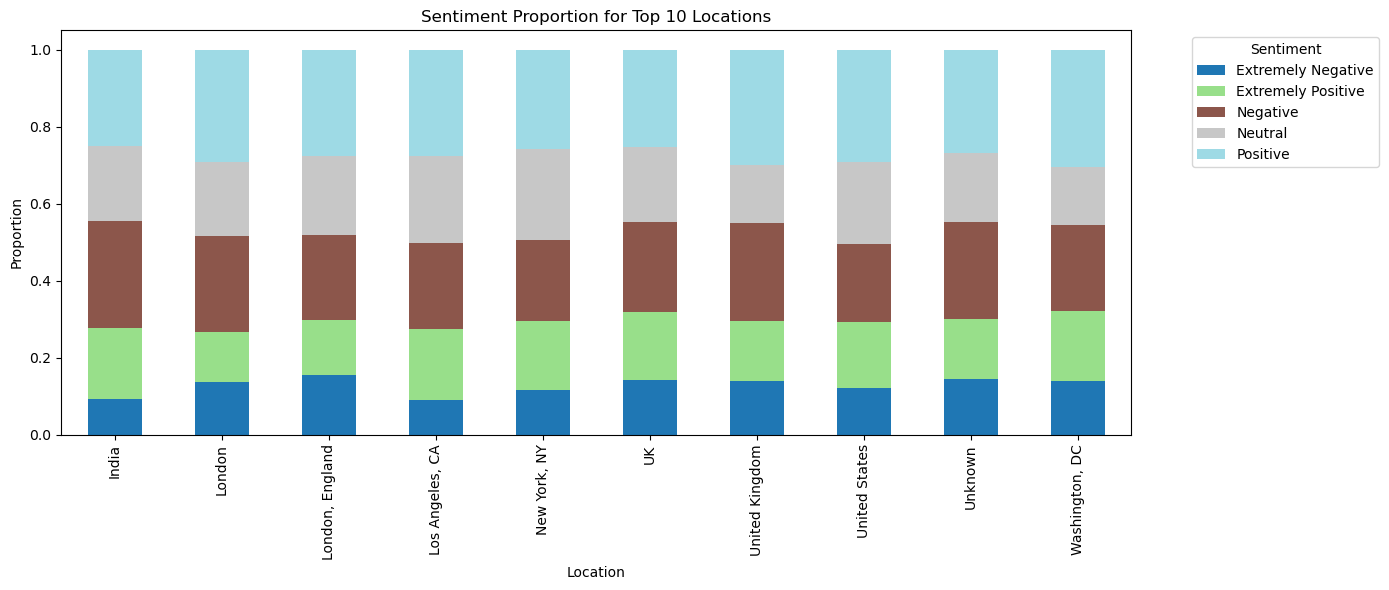

In [46]:
# Sentiment Proportions by Location  - Instead of raw counts,  see proportions for each sentiment within a location. This can reveal, for example, if "India" tweets are 70% positive while “London” tweets are 50% neutral.

loc_sent_counts = df_top_locations.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)
loc_sent_props = loc_sent_counts.div(loc_sent_counts.sum(axis=1), axis=0)

loc_sent_props.plot(kind='bar', stacked=True, figsize=(14,6), colormap='tab20')
plt.title(f'Sentiment Proportion for Top {N} Locations')
plt.xlabel('Location')
plt.ylabel('Proportion')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [47]:
# Unknown” as a Separate Group - show how “Unknown” compares to others
unknown_sent = df_train[df_train['Location'] == 'Unknown']['Sentiment'].value_counts(normalize=True)
print("Sentiment distribution for 'Unknown' location:")
print(unknown_sent)

Sentiment distribution for 'Unknown' location:
Sentiment
Positive              0.269056
Negative              0.250902
Neutral               0.179332
Extremely Positive    0.157337
Extremely Negative    0.143373
Name: proportion, dtype: float64


In [48]:
# Simple lowercasing and stripping
df_train['Location_clean'] = df_train['Location'].str.lower().str.strip()

# Show top 10 cleaned locations
print(df_train['Location_clean'].value_counts().head(10))

Location_clean
unknown            8593
london              575
united states       532
london, england     525
new york, ny        399
washington, dc      380
united kingdom      343
india               292
los angeles, ca     283
uk                  259
Name: count, dtype: int64


The `Location` field contains a mix of cities, countries, and ambiguous user-defined entries. To enable meaningful geographic visualization, we manually mapped the most frequent and recognizable cities to their corresponding countries.

Tweets from less frequent, ambiguous, or unidentifiable locations were grouped under a generic category labeled `'Other'`. This aggregation step allowed us to generate a choropleth map showing tweet distribution by country, providing a clearer and more interpretable geographic overview of the dataset.

In this section, we examined the geographic distribution of tweets using the `Location` field. We found that the data is highly heterogeneous, with over 12,000 unique entries - including cities, countries, and many ambiguous or user-defined strings. A large portion of values were missing and imputed as `'Unknown'`, which became the most common location.

To enable interpretable visualizations, we mapped the most frequent cities to their corresponding countries and grouped all remaining or unclear entries under `'Other'`. This allowed us to generate a choropleth map showing the global distribution of tweets, with the majority concentrated in the US, UK, and India.

Although sentiment trends were broadly consistent across locations, the noisy and inconsistent nature of the `Location` field limited its reliability. Still, we hypothesized that geographic context could contribute valuable signal. As such, we plan to incorporate cleaned location information directly into the LLM input, which we implement in a later step.

## Feature Analysis: Presence of URLs and Hashtags by Sentiment

We engineered features related to the presence and frequency of URLs and hashtags within tweets. By analyzing how these elements vary across sentiment classes, we gained insight into how users share information and participate in social trends.

These structural features often reflect user behavior and can carry sentiment-relevant signal. For example, hashtags may indicate topic framing, while URLs may link to emotional or informational content. We also examined the most common hashtags by sentiment to identify dominant topics and patterns in expression.

In [49]:
# Presence of URLs - Most tweets containing URLs have "http" or "https"
df_train['has_url'] = df_train['OriginalTweet'].str.contains(r'http[s]?://', regex=True)

# Number of Hashtags- A hashtag starts with "#":
df_train['hashtag_count'] = df_train['OriginalTweet'].str.count(r'#\w+')

Plot the Features by Sentiment

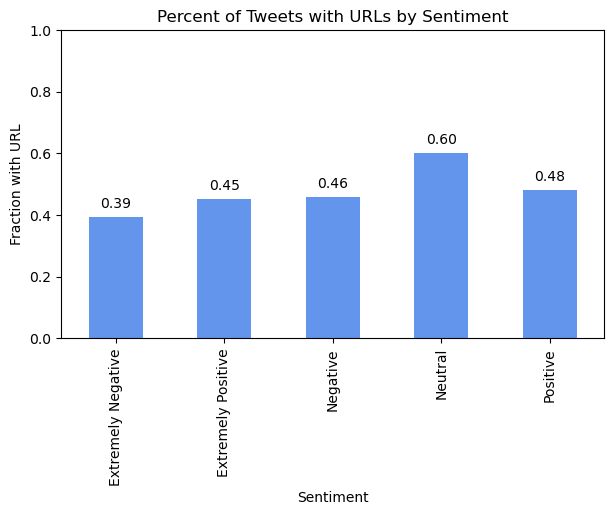

In [50]:
# Percentage of Tweets with URLs by Sentiment (with value labels)
url_by_sent = df_train.groupby('Sentiment')['has_url'].mean()

plt.figure(figsize=(7,4))
ax = url_by_sent.plot(kind='bar', color='cornflowerblue')
plt.title('Percent of Tweets with URLs by Sentiment')
plt.ylabel('Fraction with URL')
plt.ylim(0, 1)

# Add value labels on top of each bar
for i, v in enumerate(url_by_sent):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()


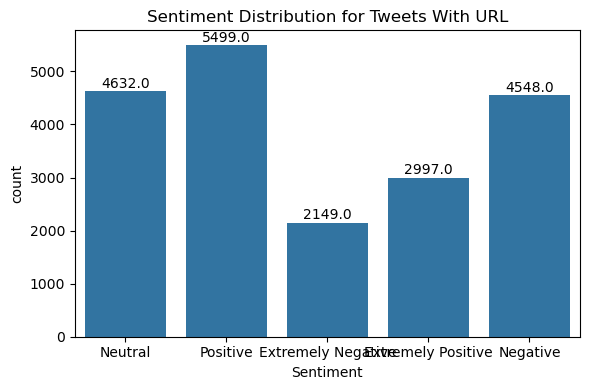

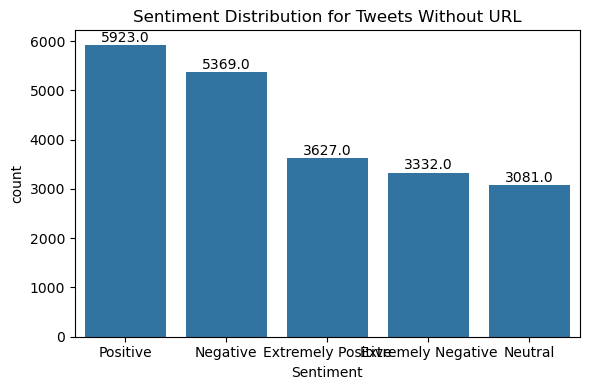

In [51]:
# Sentiment distribution for tweets with a URL
import matplotlib.pyplot as plt

# Sentiment Distribution for Tweets With URL
plt.figure(figsize=(6,4))
ax1 = sns.countplot(x='Sentiment', data=df_train[df_train['has_url'] == True])
plt.title('Sentiment Distribution for Tweets With URL')

# Add count labels
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Sentiment Distribution for Tweets Without URL
plt.figure(figsize=(6,4))
ax2 = sns.countplot(x='Sentiment', data=df_train[df_train['has_url'] == False])
plt.title('Sentiment Distribution for Tweets Without URL')

# Add count labels
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

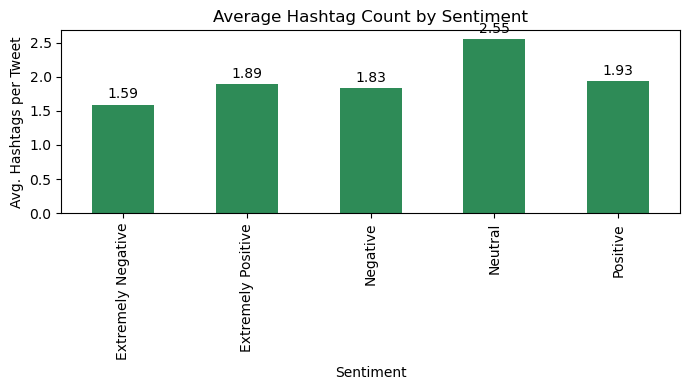

In [52]:
# Average Hashtag Count by Sentiment (with labels)
hashtag_by_sent = df_train.groupby('Sentiment')['hashtag_count'].mean()

plt.figure(figsize=(7,4))
ax = hashtag_by_sent.plot(kind='bar', color='seagreen')
plt.title('Average Hashtag Count by Sentiment')
plt.ylabel('Avg. Hashtags per Tweet')

# Add value labels
for i, v in enumerate(hashtag_by_sent):
    ax.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

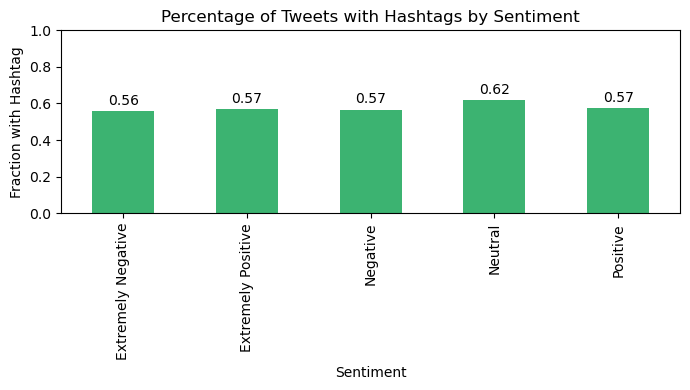

In [53]:
# Binary column for presence of at least one hashtag
df_train['has_hashtag'] = df_train['hashtag_count'] > 0

# Percentage of tweets with hashtags by sentiment
hashtag_presence = df_train.groupby('Sentiment')['has_hashtag'].mean()

plt.figure(figsize=(7,4))
ax = hashtag_presence.plot(kind='bar', color='mediumseagreen')
plt.title('Percentage of Tweets with Hashtags by Sentiment')
plt.ylabel('Fraction with Hashtag')
plt.ylim(0, 1)

# Add value labels
for i, v in enumerate(hashtag_presence):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


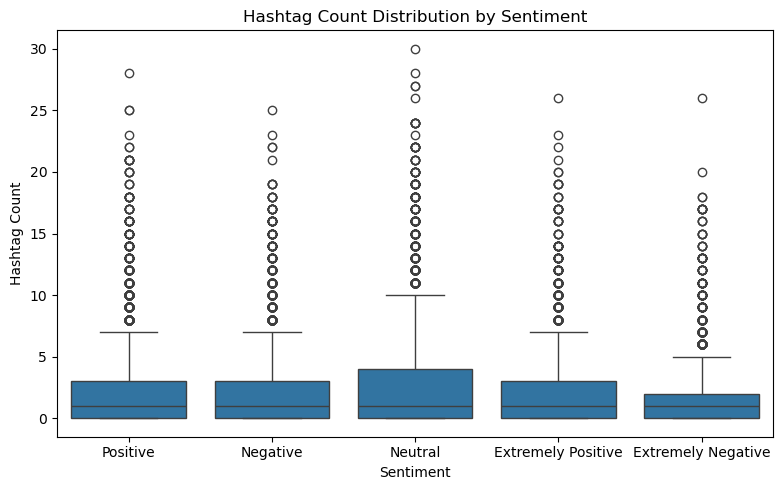

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x='Sentiment',
    y='hashtag_count',
    data=df_train,
    order=df_train['Sentiment'].value_counts().index
)
plt.title('Hashtag Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Hashtag Count')
plt.tight_layout()
plt.show()

Most Common Hashtags by Sentiment - which hashtags are most frequently used for each sentiment class.

In [55]:
# Most common hashtags by sentiment
for sentiment in df_train['Sentiment'].unique():
    hashtags = df_train[df_train['Sentiment'] == sentiment]['OriginalTweet'].str.findall(r'#\w+')
    hashtags_flat = [tag.lower() for sublist in hashtags for tag in sublist]
    common_hashtags = Counter(hashtags_flat).most_common(10)
    print(f"Most common hashtags for {sentiment}: {common_hashtags}")

Most common hashtags for Neutral: [('#coronavirus', 3362), ('#covid19', 1110), ('#covid_19', 639), ('#toiletpaper', 543), ('#covid', 388), ('#covid2019', 303), ('#socialdistancing', 237), ('#coronacrisis', 140), ('#stayhome', 128), ('#corona', 126)]
Most common hashtags for Positive: [('#coronavirus', 4363), ('#covid19', 1440), ('#covid_19', 857), ('#covid2019', 476), ('#covid', 445), ('#toiletpaper', 429), ('#socialdistancing', 277), ('#coronacrisis', 167), ('#stayhome', 133), ('#corona', 129)]
Most common hashtags for Extremely Negative: [('#coronavirus', 2065), ('#covid19', 506), ('#covid_19', 428), ('#covid2019', 231), ('#covid', 179), ('#coronacrisis', 139), ('#toiletpaper', 123), ('#socialdistancing', 68), ('#panicbuying', 67), ('#coronavirusoutbreak', 63)]
Most common hashtags for Negative: [('#coronavirus', 3783), ('#covid19', 999), ('#covid_19', 757), ('#covid2019', 407), ('#covid', 366), ('#toiletpaper', 311), ('#coronacrisis', 204), ('#socialdistancing', 177), ('#coronavirus

In [56]:
from tabulate import tabulate

# Most common hashtags by sentiment (formatted output)
for sentiment in df_train['Sentiment'].unique():
    hashtags = df_train[df_train['Sentiment'] == sentiment]['OriginalTweet'].str.findall(r'#\w+')
    hashtags_flat = [tag.lower() for sublist in hashtags for tag in sublist]
    common_hashtags = Counter(hashtags_flat).most_common(10)

    # Format for tabular display
    table = [(i+1, tag, count) for i, (tag, count) in enumerate(common_hashtags)]
    print(f"\nTop 10 Hashtags for '{sentiment}':\n")
    print(tabulate(table, headers=["Rank", "Hashtag", "Count"], tablefmt="github"))



Top 10 Hashtags for 'Neutral':

|   Rank | Hashtag           |   Count |
|--------|-------------------|---------|
|      1 | #coronavirus      |    3362 |
|      2 | #covid19          |    1110 |
|      3 | #covid_19         |     639 |
|      4 | #toiletpaper      |     543 |
|      5 | #covid            |     388 |
|      6 | #covid2019        |     303 |
|      7 | #socialdistancing |     237 |
|      8 | #coronacrisis     |     140 |
|      9 | #stayhome         |     128 |
|     10 | #corona           |     126 |

Top 10 Hashtags for 'Positive':

|   Rank | Hashtag           |   Count |
|--------|-------------------|---------|
|      1 | #coronavirus      |    4363 |
|      2 | #covid19          |    1440 |
|      3 | #covid_19         |     857 |
|      4 | #covid2019        |     476 |
|      5 | #covid            |     445 |
|      6 | #toiletpaper      |     429 |
|      7 | #socialdistancing |     277 |
|      8 | #coronacrisis     |     167 |
|      9 | #stayhome         | 

In this section, we systematically analyzed how structural features - specifically URLs and hashtags - are distributed across sentiment classes in the dataset.

Nearly half of all tweets contain a URL, with neutral tweets showing the highest prevalence. Tweets containing links tend to be more informational or neutral in tone, while tweets without links show a higher proportion of extreme sentiments (particularly negative). This indicates that URLs may carry indirect sentiment signals depending on their usage context.

Hashtag usage is also widespread, with an average of 1–2 hashtags per tweet across most sentiment classes. Tweets with a high number of hashtags (e.g., more than 10) often reflect campaign-driven or trend-focused content. Importantly, the presence and nature of hashtags appear sentiment-relevant: different hashtags dominate in different sentiment categories.

For example:
- **Positive and Extremely Positive** tweets frequently include encouraging or safety-focused hashtags such as `#stayhome`, `#staysafe`, and `#socialdistancing`.
- **Negative and Extremely Negative** tweets show more crisis- or frustration-related hashtags like `#panicbuying`, `#coronacrisis`, and `#coronavirusoutbreak`.
- **Neutral** tweets are heavily centered on factual topics, with hashtags like `#covid19`, `#toiletpaper`, and `#coronavirus`.

Across all sentiments, general pandemic-related hashtags like `#covid19`, `#coronavirus`, and `#covid_19` are among the most frequent, which aligns with the dataset’s context. However, it is the **less frequent, sentiment-specific hashtags** that offer classification value by capturing tone and topic emphasis.

These patterns demonstrate that hashtags carry meaningful semantic and emotional signals. Their distribution is not random but correlates with sentiment, making them a valuable source of auxiliary information for downstream modeling. Based on this insight, we chose to explicitly preserve and structure hashtags in our enriched input format to allow the language model to benefit from their predictive potential.

## Additional Text Feature Analysis

In this section, we examine additional textual features that may carry sentiment-relevant signals. These include:

- The ratio of ALL CAPS words (e.g., "shouting")
- Frequency of special punctuation (e.g., `!`, `?`, `#`)
- Presence of COVID-related keywords (e.g., "pandemic", "vaccine", "lockdown")
- Presence of numeric content (e.g., case counts, dates, statistics)

These features may reflect the intensity of emotion, urgency, or informational tone, and could contribute auxiliary signal for sentiment classification.

We begin by computing and visualizing the ratio of ALL CAPS words per tweet, to evaluate whether certain sentiments (e.g., negative or extreme ones) tend to include more capitalized emphasis.

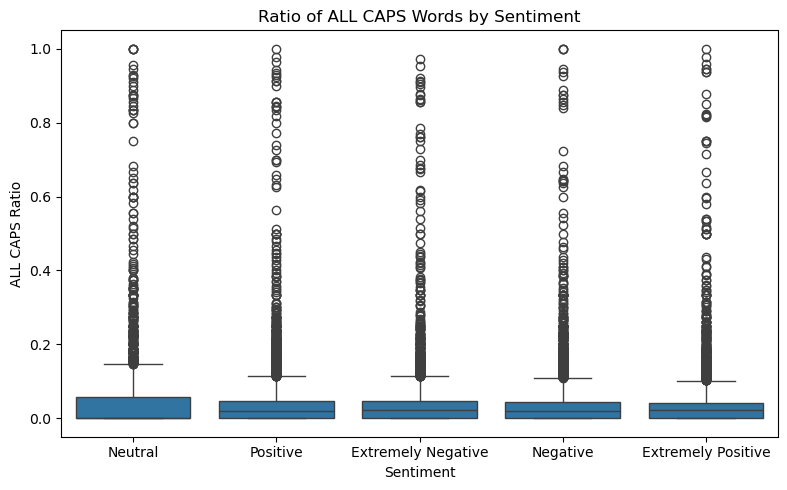

In [57]:
# ALL CAPS word ratio per tweet
def all_caps_ratio(text):
    words = str(text).split()
    all_caps = [w for w in words if w.isupper() and len(w) > 1]
    return len(all_caps) / len(words) if words else 0

df_train['all_caps_ratio'] = df_train['OriginalTweet'].apply(all_caps_ratio)

# Boxplot of ALL CAPS ratio by sentiment
plt.figure(figsize=(8,5))
sns.boxplot(x='Sentiment', y='all_caps_ratio', data=df_train)
plt.title('Ratio of ALL CAPS Words by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('ALL CAPS Ratio')
plt.tight_layout()
plt.show()


### Punctuation Intensity by Sentiment

Analyze the frequency of punctuation marks (like !, ?, #) by sentiment - sometimes more emotion = more punctuation.

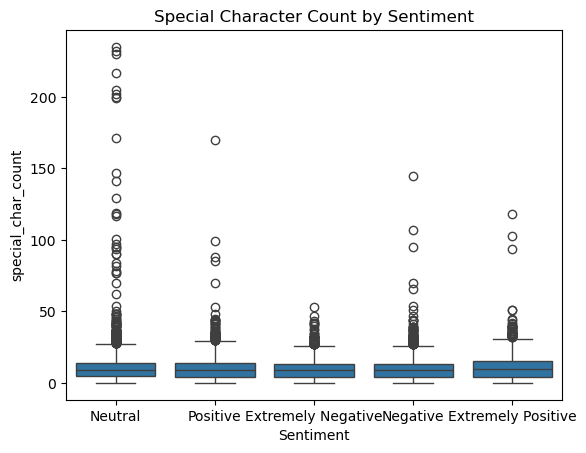

In [58]:
# Count of all punctuation characters per tweet

df_train['special_char_count'] = df_train['OriginalTweet'].apply(lambda x: sum(1 for c in str(x) if c in string.punctuation))
sns.boxplot(x='Sentiment', y='special_char_count', data=df_train)
plt.title('Special Character Count by Sentiment')
plt.show()

### COVID Keyword Frequency by Sentiment

Keyword Analysis: Look as a specific list of Covid words and check which sentiments use these keywords the most.

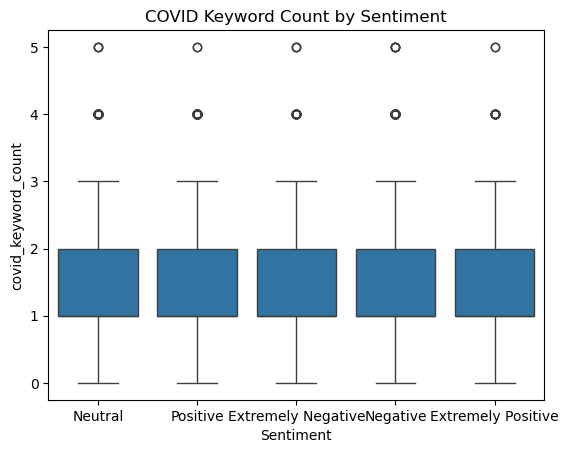

In [59]:
# Count of predefined COVID-related keywords per tweet
covid_keywords = ['covid', 'corona', 'pandemic', 'lockdown', 'vaccine', 'quarantine', 'cases', 'death', 'infection', 'symptom']
def keyword_count(text):
    return sum(word in str(text).lower() for word in covid_keywords)
df_train['covid_keyword_count'] = df_train['OriginalTweet'].apply(keyword_count)
sns.boxplot(x='Sentiment', y='covid_keyword_count', data=df_train)
plt.title('COVID Keyword Count by Sentiment')
plt.show()

### Presence of Numbers by Sentiment
Presence of Numbers: Check if the tweet contain numbers? Sometimes case/death counts, dates, or statistics are mentioned more in negative/informational tweets.

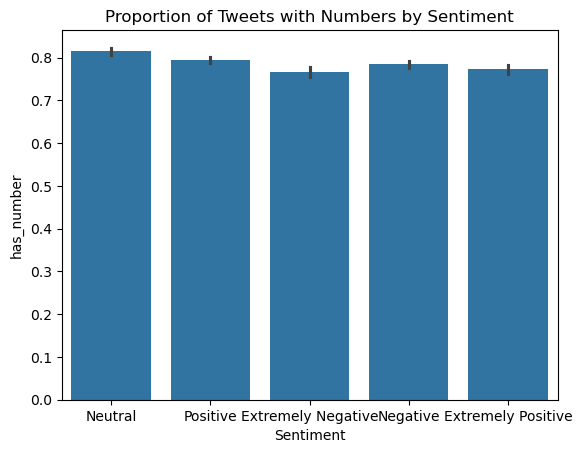

In [60]:
# Binary indicator for presence of numeric digits in the tweet
df_train['has_number'] = df_train['OriginalTweet'].str.contains(r'\d', regex=True)
sns.barplot(x='Sentiment', y='has_number', data=df_train)
plt.title('Proportion of Tweets with Numbers by Sentiment')
plt.show()

In this subsection, we expanded our feature analysis by exploring a range of linguistic and content-based tweet attributes - specifically, the ratio of ALL CAPS words, frequency of special punctuation marks, use of COVID-related keywords, and the presence of numbers. These features provide deeper insight into the expressive styles and informational content found across different sentiment classes.

Our findings show that the ratio of ALL CAPS words is generally low across all sentiments, but there is a subset of tweets that exhibit a higher concentration of “shouting,” as reflected by the upper outliers. This suggests that intense emotions, particularly anger or urgency, may be communicated via capitalized words, though this is not exclusive to one specific sentiment. Similarly, special character counts (such as exclamation marks, question marks, and other punctuation) are fairly consistent among sentiments, with more outliers in neutral tweets, this may indicate that expressive punctuation is another marker of emotional tone, but is not strongly sentiment specific.

Turning to content, the frequency of COVID-related keywords is high and remarkably similar across all sentiment categories, reinforcing the centrality of pandemic discourse during the sampled period. The distribution of COVID terms is broad, supporting the observation from earlier sections that COVID-19 was a dominant topic regardless of sentiment polarity.

Finally, the presence of numbers is widespread in all sentiment classes, with neutral tweets showing a slightly higher fraction of numeric content. This likely reflects the sharing of factual information, such as case counts, dates, or public health statistics.

In conclusion, these textual feature analyses highlight that while certain expressive markers (such as ALL CAPS and special punctuation) are weakly associated with some sentiments, none of these features alone strongly separates the sentiment classes. However, their prevalence - along with pandemic keywords and numbers - underscores the informational, event-driven nature of the dataset. Overall, these features can provide useful auxiliary signals for sentiment modeling, particularly for detecting emotion intensity or distinguishing between opinion-based and information-driven tweets.

## Data Cleaning   

Before moving to modeling, we clean the data by removing tweets that contain no meaningful language content for future classifier and can hurt model performance as the model will learn to recognize noise and not sentiment. This such data are tweets consisting only of symbols or punctuatuion, URLs, hashtags, or that become empty after cleaning. This ensures that our models are trained on valid, information-rich text samples and are not biased by noise or irrelevant content.

In [61]:
# Remove tweets that are only URLs
url_pattern = r'^\s*https?://\S+\s*$'
only_url = df_train['OriginalTweet'].str.match(url_pattern, na=False)
print(f"Rows that are only a URL: {only_url.sum()}")

Rows that are only a URL: 0


In [62]:
# Remove tweets that are only symbols/punctuation
def is_only_symbols(text):
    # Remove whitespace
    stripped = str(text).strip()
    # If after removing all punctuation, the string is empty, it's only symbols
    return stripped and all(char in string.punctuation for char in stripped)

only_symbols = df_train['OriginalTweet'].apply(is_only_symbols)
print(f"Rows that are only symbols/punctuation: {only_symbols.sum()}")

Rows that are only symbols/punctuation: 0


In [63]:
# Remove tweets that are blank/empty after stripping whitespace

only_empty = df_train['OriginalTweet'].astype(str).str.strip() == ''
print(f"Rows that are blank/empty: {only_empty.sum()}")

Rows that are blank/empty: 0


In [64]:
to_remove = only_url | only_symbols | only_empty
print(f"Total rows to remove: {to_remove.sum()}")

Total rows to remove: 0


#### Find "garbage" tweets – filter out tweets that contain only punctuation, URLs, or other non-informative symbols.

Initial approach:
We started by removing URLs, hashtags, and mentions from the tweets, and then filtered out any tweet that did not contain any remaining alphanumeric characters. This allowed us to discard tweets that were essentially noise – such as those made up only of symbols, links, or tags – and retain only tweets with meaningful text content.

Updated approach:
However, we realized that hashtags and mentions may carry valuable semantic information (e.g., topic identifiers or user references), even if no other text is present. Therefore, we revised the method to preserve hashtags and mentions when evaluating tweet content.

Final method:
Now, we only remove URLs and punctuation while retaining hashtags and mentions. We consider a tweet to contain "real" text if, after cleaning, it includes at least one alphanumeric character or a hashtag/mention. This more inclusive filter retains tweets that consist solely of tags or mentions, acknowledging their potential value in downstream tasks like topic modeling or classification.

In [65]:
# Find "garbage" tweets

def has_real_text(text):

    # Remove URLs
    no_urls = re.sub(r'http[s]?://\S+', '', str(text))

    # Only remove non-alphanumeric characters except @ and #
    cleaned = re.sub(r'[^a-zA-Z0-9@#]', '', no_urls)
    return cleaned.strip() != ''

mask_has_real_text = df_train['OriginalTweet'].apply(has_real_text)
print(f"Number of tweets with real text: {mask_has_real_text.sum()}")
print(f"Number of tweets WITHOUT real text: {(~mask_has_real_text).sum()}")

Number of tweets with real text: 41152
Number of tweets WITHOUT real text: 5


In [66]:
import re

# Keep tweets that are hashtags/mentions only
def has_real_text(text):
    # Remove URLs
    no_urls = re.sub(r'http[s]?://\S+', '', str(text))

    # DO NOT remove hashtags and mentions
    # Remove all non-letter/number characters EXCEPT # and @
    cleaned = re.sub(r'[^a-zA-Z0-9@#]', '', no_urls)

    # Return True if there's still content (letters, numbers, #, or @)
    return cleaned.strip() != ''

mask_has_real_text = df_train['OriginalTweet'].apply(has_real_text)

print(f"Number of tweets with real text or tags/mentions: {mask_has_real_text.sum()}")
print(f"Number of tweets WITHOUT any text, tags or mentions: {(~mask_has_real_text).sum()}")


Number of tweets with real text or tags/mentions: 41152
Number of tweets WITHOUT any text, tags or mentions: 5


In [67]:
df_train[~mask_has_real_text].head(29)['OriginalTweet']

13843    ? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...
16920    ???? ??????? ??????? ???? ????? ???? ???? ????...
18437    ????? ?? ??????? ?? ??????? ???? ???? ????????...
32455      ?? ?? ??? ??? ??? ????! https://t.co/2VAcVOugv1
36781    ??? ???? ????? ?? ?????? ???? ????? ? ???? ???...
Name: OriginalTweet, dtype: object

In [68]:
# Proportion of tweets with no actual text
proportion = (~mask_has_real_text).sum()/df_train.shape[0]
print(f"Proportion of tweets WITHOUT real text: {proportion}")

Proportion of tweets WITHOUT real text: 0.00012148601695944797


We removed tweets that, after cleaning, contained no alphanumeric content, excluding those with only punctuation or URLs. Hashtags and mentions were kept, as they may carry useful information. This ensured we filtered out only truly non-informative tweets.

In [69]:
# Remove tweets that don't have real text:
df_train_cleaned = df_train[mask_has_real_text].copy()

# Final Preprocessing

Before sentiment modeling, we cleaned the data to ensure it included only tweets with meaningful content. We first checked for tweets that were just URLs, symbols, or blank – none were found. Then, we applied a stricter filter to remove tweets made up only of URLs or non-alphanumeric symbols, while preserving hashtags and mentions. This led to the removal of 5 tweets (0.01%) that lacked usable language. Cleaning out these noise-heavy tweets improves model focus and reliability in downstream sentiment analysis.

Extracting Content from URLs<br>
This function follows the shortened URL and tries to extract meaningful text - either the path or the title of the page. For Twitter/X links, it simply tags them.

In [70]:
"""pip install orjson"""

'pip install orjson'

In [71]:
import os
import re
import time
import random
import requests
import orjson
from urllib.parse import urlparse
from bs4 import BeautifulSoup
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.exceptions import Timeout, TooManyRedirects, RequestException

CACHE_FILE = "url_cache.json"
MAX_WORKERS = min(16, os.cpu_count() * 2)

def safe_get(url):
    try:
        resp = requests.get(
            url,
            timeout=(0.5, 0.5),
            allow_redirects=True,
            headers={"User-Agent": "Mozilla/5.0"},
        )
        return resp.url, resp.text
    except (Timeout, TooManyRedirects, RequestException):
        return None, None

def _resolve(url):
    time.sleep(random.uniform(0.05, 0.15))
    final, html = safe_get(url)
    if final is None:
        return url, "unreachable_url"

    dom = urlparse(final).netloc.lower()
    if dom.endswith("twitter.com") or dom.endswith("x.com"):
        return url, "twitter_post"

    soup = BeautifulSoup(html, "html.parser")
    title = soup.title.string.strip() if soup.title and soup.title.string else ""
    path = urlparse(final).path.strip("/").replace("-", " ").replace("/", " / ")
    return url, (title or path or "no_title")

def resolve_urls_in_bulk(df, url_column="OriginalTweet", wb_run=None):
    all_text = " ".join(df[url_column])
    unique_urls = list(set(re.findall(r"https?://t\.co/\w+", all_text)))

    # Load cache
    cache = {}
    if os.path.exists(CACHE_FILE):
        try:
            with open(CACHE_FILE, "rb") as f:
                cache = orjson.loads(f.read())
        except:
            cache = {}

    to_resolve = [u for u in unique_urls if u not in cache]
    resolved_now = {}

    if to_resolve:
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
            futures = {ex.submit(_resolve, url): url for url in to_resolve}
            for future in tqdm(as_completed(futures), total=len(futures), desc="Resolving URLs", unit="url", leave=False):
                url = futures[future]
                if future.done():
                    try:
                        result_url, content = future.result()
                        resolved_now[result_url] = content
                    except:
                        resolved_now[url] = "unreachable_url"
                else:
                    future.cancel()
                    resolved_now[url] = "unreachable_url"

        cache.update(resolved_now)
        with open(CACHE_FILE, "wb") as f:
            f.write(orjson.dumps(cache))

    return {u: cache.get(u, "unreachable_url") for u in unique_urls}


Transform Individual Tweet<br>
This transforms a single tweet by:
* Removing shortened URLs and replacing with meaningful description.
* Extracting hashtags and mentions.
* Reformatting the content into sections.

In [72]:
# Chunk 3: transform_tweet (one [url] per description)
def transform_tweet(tweet, url_map):
    # 1. Extract & replace t.co URLs
    urls = re.findall(r"https?://t\.co/\w+", tweet)
    url_contents = []
    for url in urls:
        desc = url_map.get(url, None)
        if desc and desc != "unreachable_url" and desc != "twitter_post":
            url_contents.append(desc)
        tweet = tweet.replace(url, "")

    # 2. Extract hashtags & mentions (no symbols)
    hashtags = re.findall(r"#(\w+)", tweet)
    mentions = re.findall(r"@(\w+)", tweet)

    # 3. Remove them from text and clean whitespace
    tweet = re.sub(r"(#\w+|@\w+)", "", tweet)
    tweet_clean = re.sub(r"\s+", " ", tweet).strip()

    # 4. Build segments: tweet, then one [url] per description, then hashtags/mentions
    parts = [f"[tweet] {tweet_clean}"]
    for desc in url_contents:
        parts.append(f"[url] {desc}")
    if hashtags:
        parts.append(f"[hashtags] {' '.join(hashtags)}")
    if mentions:
        parts.append(f"[mentions] {' '.join(mentions)}")

    return " ".join(parts)

Add Transformed Tweet Column to DataFrame<br>
This applies the transformation to all rows in the dataset.

In [73]:
def add_transformed_column(df, url_map):
    df["TweetTransformed"] = (
        df["OriginalTweet"]
        .apply(lambda x: transform_tweet(x, url_map))
    )
    return df

Add 'TweetAt' (Date) to Transformed Tweet<br>
This appends the date in human-readable English format.

In [74]:
"""def add_date_to_transformed(df):
    def convert_date_format(date_str):
        try:
            dt = datetime.strptime(date_str, "%d-%m-%Y")
            return dt.strftime("%B %d, %Y")
        except:
            return None

    def append_date(row):
        date_text = convert_date_format(row["TweetAt"])
        if date_text:
            return f"{row['TweetTransformed']} [date] {date_text}"
        else:
            return row["TweetTransformed"]

    df["TweetWithDate"] = df.apply(append_date, axis=1)
    return df"""

def add_date_to_transformed(df):
    # Parse with pandas; handles strings or already-parsed datetimes
    dt = pd.to_datetime(df["TweetAt"], errors="coerce", infer_datetime_format=True, dayfirst=False)
    # Format as "March 16, 2020"
    nice = dt.dt.strftime("%B %d, %Y")
    # Append when parsing succeeded (notna), else leave as-is
    df["TweetWithDate"] = df["TweetTransformed"].where(nice.isna(), df["TweetTransformed"] + " [date] " + nice)
    return df

Add 'Location' to Transformed Tweet<br>
This appends the location (if available) to the transformed tweet.

In [75]:
def add_location_to_transformed(df):
    def append_loc(row):
        loc = row.get("Location", None)
        if pd.notna(loc) and str(loc).strip():
            return f"{row['TweetWithDate']} [location] {loc}"
        else:
            return row["TweetWithDate"]

    df["TweetWithDateLocation"] = df.apply(append_loc, axis=1)
    return df

Full Pipeline Function<br>
This calls all previous steps in order and returns the final DataFrame.

In [76]:
def full_enrich_tweet_pipeline(df):
    url_map = resolve_urls_in_bulk(df)
    df = add_transformed_column(df, url_map)
    df = add_date_to_transformed(df)
    df = add_location_to_transformed(df)
    return df

### Note on URL Resolution and Preprocessed Output

The URL resolution step involves web scraping and may take a considerable amount of time - potentially **over 30 minutes**, depending on network conditions and the number of unique links in the dataset. To save time and ensure reproducibility, we provide the final enriched DataFrames (`df_train_with_urls.csv` and `df_test_with_urls.csv`) **after URL resolution has been completed**.

For users who wish to inspect or rerun the URL enrichment pipeline themselves, the full scraping logic is included and can be activated by simply **removing the comment tags** (`"""..."""`) around the relevant code.

Additionally, we implemented a **caching mechanism (`url_cache.json`)**, which stores previously resolved URL contents. This allows users to:
- Skip repeated downloads for already-resolved links
- Verify the correctness of the resolution logic without re-scraping all URLs
- Inspect or update the cache as needed

This setup balances **efficiency**, **reproducibility**, and **transparency**, while still giving users full control to rerun the process from scratch if desired.

In [ ]:
"""df_train_enrich = df_train_cleaned.copy()
df_train_enrich = full_enrich_tweet_pipeline(df_train_enrich)
df_train_enrich.to_csv("df_train_with_urls.csv")
df_train_enrich.head()"""

C:\Users\iliya\AppData\Local\Temp\ipykernel_13576\4151789337.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(df["TweetAt"], errors="coerce", infer_datetime_format=True, dayfirst=False)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text_length_chars,text_length_words,day,month,...,has_url,hashtag_count,has_hashtag,all_caps_ratio,special_char_count,covid_keyword_count,has_number,TweetTransformed,TweetWithDate,TweetWithDateLocation
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,8,16,3,...,True,0,False,0.000000,19,0,True,[tweet] and and [mentions] MeNyrbie Phil_Gahan...,[tweet] and and [mentions] MeNyrbie Phil_Gahan...,[tweet] and and [mentions] MeNyrbie Phil_Gahan...
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,237,38,16,3,...,False,0,False,0.026316,0,0,False,[tweet] advice Talk to your neighbours family ...,[tweet] advice Talk to your neighbours family ...,[tweet] advice Talk to your neighbours family ...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,131,14,16,3,...,True,0,False,0.071429,8,2,True,[tweet] Coronavirus Australia: Woolworths to g...,[tweet] Coronavirus Australia: Woolworths to g...,[tweet] Coronavirus Australia: Woolworths to g...
3,3802,48754,Unknown,2020-03-16,My food stock is not the only one which is emp...,Positive,306,42,16,3,...,True,7,True,0.238095,22,2,True,[tweet] My food stock is not the only one whic...,[tweet] My food stock is not the only one whic...,[tweet] My food stock is not the only one whic...
4,3803,48755,Unknown,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310,40,16,3,...,True,6,True,0.025000,23,2,True,"[tweet] Me, ready to go at supermarket during ...","[tweet] Me, ready to go at supermarket during ...","[tweet] Me, ready to go at supermarket during ..."


In [78]:
df_train_enrich = pd.read_csv("df_train_with_urls.csv")
df_train_enrich.iloc[12,:].TweetWithDateLocation

'[tweet] is a caring community. LetÂ\x92s ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. [url] COVID-19 - NHS [hashtags] horningsea [date] March 16, 2020 [location] Horningsea'

In [ ]:
"""df_test_enrich = df_test.copy()
df_test_enrich  = full_enrich_tweet_pipeline(df_test_enrich)
df_test_enrich.to_csv("df_test_with_urls.csv")
df_test_enrich.head()"""

C:\Users\iliya\AppData\Local\Temp\ipykernel_13576\4151789337.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(df["TweetAt"], errors="coerce", infer_datetime_format=True, dayfirst=False)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,TweetTransformed,TweetWithDate,TweetWithDateLocation
0,1,44953,NYC,2020-03-02,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,[tweet] TRENDING: New Yorkers encounter empty ...,[tweet] TRENDING: New Yorkers encounter empty ...,[tweet] TRENDING: New Yorkers encounter empty ...
1,2,44954,"Seattle, WA",2020-03-02,When I couldn't find hand sanitizer at Fred Me...,Positive,[tweet] When I couldn't find hand sanitizer at...,[tweet] When I couldn't find hand sanitizer at...,[tweet] When I couldn't find hand sanitizer at...
2,3,44955,NaN,2020-03-02,Find out how you can protect yourself and love...,Extremely Positive,[tweet] Find out how you can protect yourself ...,[tweet] Find out how you can protect yourself ...,[tweet] Find out how you can protect yourself ...
3,4,44956,Chicagoland,2020-03-02,#Panic buying hits #NewYork City as anxious sh...,Negative,[tweet] buying hits City as anxious shoppers s...,[tweet] buying hits City as anxious shoppers s...,[tweet] buying hits City as anxious shoppers s...
4,5,44957,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,[tweet] One week everyone buying baby milk pow...,[tweet] One week everyone buying baby milk pow...,[tweet] One week everyone buying baby milk pow...


In [80]:
df_test_enrich = pd.read_csv("df_test_with_urls.csv")
df_test_enrich.iloc[4,:].TweetWithDateLocation

'[tweet] One week everyone buying baby milk powder the next everyone buying up toilet paper. [hashtags] toiletpaper dunnypaper coronavirus coronavirusaustralia CoronaVirusUpdate Covid_19 9News Corvid19 7NewsMelb dunnypapergate Costco [date] March 03, 2020 [location] Melbourne, Victoria'

### Post-processing to Fix Character Encoding Issues

Due to inconsistent text encodings across sources (e.g., tweets and resolved URLs), some characters may appear corrupted - such as `LetÂ\x92s` instead of `Let’s`. This issue is caused by decoding mismatches, often between UTF-8 and Latin1.

Rather than re-run the full scraping and enrichment process (which is time-consuming), we apply a lightweight post-processing fix using the `ftfy` (Fix Text For You) library.

Below, we first demonstrate the fix on a known problematic example from `df_train_enrich`, showing the difference between the corrupted and corrected versions. We then apply the fix to the entire `TweetWithDateLocation` column in both train and test sets.

This preserves the enrichment results while cleaning up display and semantic issues caused by encoding artifacts.

In [ ]:
"""pip install ftfy"""

'pip install ftfy'

In [81]:
from ftfy import fix_text

a = df_train_enrich.iloc[12:14]['TweetWithDateLocation']  # two rows
a_fixed = a.apply(fix_text)

for original, fixed in zip(a, a_fixed):
    print("ORIGINAL:", original)
    print("FIXED   :", fixed)
    print("---")

ORIGINAL: [tweet] is a caring community. LetÂs ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. [url] COVID-19 - NHS [hashtags] horningsea [date] March 16, 2020 [location] Horningsea
FIXED   : [tweet] is a caring community. Let's ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. [url] COVID-19 - NHS [hashtags] horningsea [date] March 16, 2020 [location] Horningsea
---
ORIGINAL: [tweet] Me: I don't need to stock up on food, I'll just have Amazon deliver whatever I need Amazon: [hashtags] CoronaVirus [date] March 16, 2020 [location] Chicago, IL
FIXED   : [tweet] Me: I don't need to stock up on food, I'll just have Amazon deliver whatever I need Amazon: [hashtags] 

In [82]:
# Apply fix to full column in train and test
df_train_enrich['TweetWithDateLocation'] = df_train_enrich['TweetWithDateLocation'].apply(fix_text)
df_test_enrich['TweetWithDateLocation'] = df_test_enrich['TweetWithDateLocation'].apply(fix_text)

### Final Output

After applying the post-processing fix to correct encoding artifacts, we save the enriched and cleaned DataFrames to CSV files. These represent the final preprocessed inputs, ready for model fine-tuning.

- `df_train_final.csv`
- `df_test_final.csv`

In [83]:
# Save final cleaned versions
df_train_enrich.to_csv("df_train_final.csv", index=False)
df_test_enrich.to_csv("df_test_final.csv", index=False)


In [84]:
# Add columns for tweet length in characters and words
df_train_enrich['text_length_chars'] = df_train_enrich['TweetWithDateLocation'].astype(str).apply(len)
df_train_enrich['text_length_words'] = df_train_enrich['TweetWithDateLocation'].astype(str).apply(lambda x: len(x.split()))

In [85]:
# Summary statistics table
summary_stats = df_train_enrich.groupby('Sentiment')[['text_length_chars', 'text_length_words']].describe().round(2)
display(summary_stats)

text_length_chars                                     \
                               count    mean    std   min    25%    50%   
Sentiment                                                                 
Extremely Negative            5481.0  280.49  64.39  63.0  240.0  293.0   
Extremely Positive            6624.0  282.89  60.49  70.0  246.0  295.0   
Negative                      9917.0  262.43  71.43  67.0  209.0  272.0   
Neutral                       7708.0  225.05  77.74  57.0  162.0  222.0   
Positive                     11422.0  264.10  70.31  69.0  213.0  275.0   

                                 text_length_words                           \
                      75%    max             count   mean    std  min   25%   
Sentiment                                                                     
Extremely Negative  325.0  592.0            5481.0  44.80  11.02  9.0  38.0   
Extremely Positive  326.0  573.0            6624.0  44.87  10.30  9.0  38.0   
Negative            318.0  720.0            9917.0  41.25  11.96  8.0  32.0   
Neutral             287.0  742.0            7708.0  33.95  12.33  8.0  24.0   
Positive            318.0  539.0           11422.0  41.38  11.80  8.0  33.0   

                                       
                     50%   75%    max  
Sentiment                              
Extremely Negative  46.0  53.0   94.0  
Extremely Positive  46.0  52.0   96.0  
Negative            42.0  50.0  118.0  
Neutral             33.0  43.0  115.0  
Positive            42.0  50.0   91.0

The choice of max_length = 128 for the BERT tokenizer is well justified based on the summary statistics of tweet lengths. According to the data, the maximum number of words in any tweet across all sentiment classes is 114, while the 75th percentile remains below 50 words. Since tokenizers like BERT’s often split a single word into multiple subword tokens, especially in informal social media text, the actual number of tokens can exceed the word count. Therefore, setting the maximum sequence length to 128 ensures that even the longest tweets are unlikely to be truncated after tokenization. At the same time, this length is not excessively large, avoiding unnecessary padding for the majority of tweets and maintaining computational efficiency. Using 128 as the limit offers a good balance between covering the data and optimizing model performance.

## Preprocessing Strategy: From Exploration to Enrichment

Throughout the exploratory phase, we identified several structural and contextual tweet components - such as hashtags, mentions, URLs, posting dates, and locations - that could potentially influence sentiment expression. Instead of discarding these elements, we recognized them as rich sources of auxiliary information.

We initially experimented with basic cleaning operations such as removing tweets that were empty, contained only URLs or symbols, or lacked meaningful text. These steps helped reduce noise and improve overall dataset quality.

Next, we turned our attention to how additional context - such as the presence of links or hashtags - might be leveraged rather than discarded. We explored the distribution and correlation of these features across sentiments and recognized that their presence alone may carry predictive value.

At this point, we began considering how best to integrate these diverse signals into the input format for a language model. We wanted the model to be exposed to all relevant information, while also preserving readability and clarity within each example.

Rather than engineer each feature separately (e.g., using one-hot encodings or numeric features), we decided to **consolidate** all tweet-related content into a single textual input that includes core tweet text alongside metadata elements like date, location, hashtags, mentions, and resolved URL content.

This decision was driven by the strengths of large language models: they are capable of capturing subtle context, structure, and topic-level relationships from text alone - if the input is formatted cleanly and consistently. We hypothesized that by presenting the model with a unified and semantically structured input, it could implicitly learn from patterns across all components without needing separate processing logic for each.

The enriched input format was implemented in stages - first cleaning and normalizing tweets, then resolving URLs, and finally appending contextual elements. This flexible pipeline allowed us to experiment with different variations and combinations of enriched data.

In the next section, we detail the exact input structure we finalized for LLM fine-tuning, along with the decisions and tradeoffs behind it.


## Final Decision: Unified Enriched Input for LLM

After completing our exploratory data analysis and evaluating multiple preprocessing options, we decided to consolidate each tweet and its auxiliary information into a **single enriched text format**. This unified input includes:

- The main tweet content (`[tweet]`)
- Resolved URL descriptions (`[url]`)
- Hashtags and mentions as separate sections (`[hashtags]`, `[mentions]`)
- Human-readable posting date (`[date]`)
- Location string if available (`[location]`)

Each component is clearly segmented using custom tokens (e.g., `[url]`, `[hashtags]`) to preserve structure and reduce ambiguity. We only include sections that contain non-empty content, avoiding unnecessary noise.

This design choice is guided by the strengths of large language models: they excel at extracting semantic patterns from natural text when provided in a consistent format. By merging structured metadata directly into the input, we allow the model to learn from context and interactions across all components - without requiring hand-crafted features or parallel inputs.

We chose this approach over traditional feature engineering or sparse representation methods because:
- It leverages the pretrained language model's capacity for contextual learning.
- It avoids feature fragmentation and alignment issues.
- It maintains readability, interpretability, and flexibility for further experimentation.

Ultimately, this enriched format allows us to preserve all potentially meaningful signals - from textual content to temporal and geographic context - in a way that is both model-friendly and semantically expressive. This unified structure serves as the foundation for fine-tuning our sentiment classification model.